In [22]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import fnmatch

from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astroquery.mast import Observations
from astroquery.mast import Catalogs

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (8,6)
sb.set()

################################
# Initialisers
################################

fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
isplanetarr = np.load("isplanetlist.npy")

In [2]:
################################
# FUNCTIONS
################################

def DrawLC(fitsFile=-1):
    
    # rndFile is random, unless specified
    fitsFile = random.randint(0,len(fitsarr)) if fitsFile==-1 else fitsFile
    
    # Get LC data from the requisite fits file
    #fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)


Base Data for all SKLearn Examples

8925


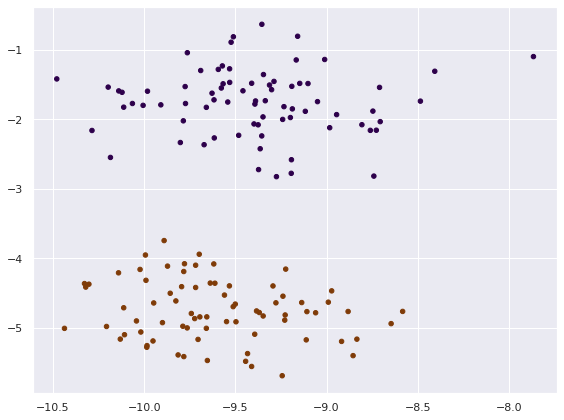

In [10]:
RND = 8925
print(RND)

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, centers=2,
                  random_state=RND, cluster_std=0.45)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');

#plt.ylim(-1,8)
#plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('img/base-sklearn-ex.png')

The below was for recreating the SVM graphs in Jake VanDerPlas' book - shouldn't do this!

In [ ]:
#RND = int(random.random()*9999)
RND = 8925
print(RND)

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, centers=2,
                  random_state=RND, cluster_std=0.45)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');

#plt.ylim(-1,8)
#plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('img/svm-ex.png')

In [ ]:
xfit = np.linspace(-10, 0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1.5, 11.8), (1, 8.7), (0, 3)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')

plt.ylim(-1,8)
plt.xlim(-10,-2)

plt.tight_layout()
#plt.savefig('img/svm-2.png')

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b, d in [(1.5, 11.8, 0.4), (1, 8.7, 0.65), (-0.1, 1.9, 0.35)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.ylim(-1,8)
plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('imgs/svm-3.png')

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

In [ ]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=1, linewidth=20, facecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr')
plt.ylim(-1,8)
plt.xlim(-10,-2)
#plt.ylim(1,2)
#plt.xlim(-7,-6.5)
plt.tight_layout()

plot_svc_decision_function(model);

plt.savefig('imgs/svm-4.png')

In [ ]:
# y = 3x-6

rng = np.random.RandomState(14)
npts = 40

x = 15 * rng.rand(npts)
y = 3 * x - 6 + (2*rng.randn(npts))
plt.xlim(0,16)
plt.ylim(-15,45)
plt.tight_layout()
plt.scatter(x, y, s=20, c="black");

plt.savefig('imgs/linreg-1.png')

Finding out what the Newsgroups are in the Naive-Bayes example in Python handbook (and how large they are)

In [ ]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
data = fetch_20newsgroups()
data.target_names

In [ ]:
print(len(data.filenames))
data.filenames

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [ ]:
print(train.data[0])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [ ]:
model

In [ ]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="RdYlGn",
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [ ]:
phrase="i want my laptop fixed"

predict_category(phrase)

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.bar([0,1,2,3,4,5,6],[0.6,0.23,0.65,0.78,0.11,0.05,0.99],tick_label=['SVM','SVM_FFT','RT','RT_FFT','NB','BN_FFT','ETC'])
plt.title("Bar graph of the Accuracy Values of the several Machine Learning methods", fontsize=18)
plt.savefig('img/examplemetrics.png')

Custom Gaussian Naive Bayes graphs for demonstration purposes

8925


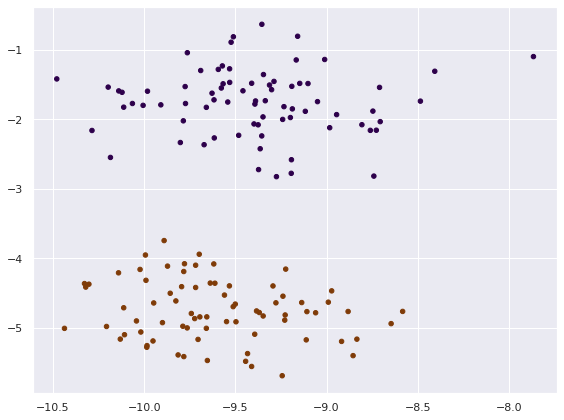

In [43]:
RND = 8925
print(RND)

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, centers=2,
                  random_state=RND, cluster_std=0.45)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');

#plt.ylim(-1,8)
#plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('img/gnb-ex.png')

ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()

In [73]:
orange_mean = [-9.60638165, -4.75583972]
purple_mean = [-9.39793607, -1.75974356]

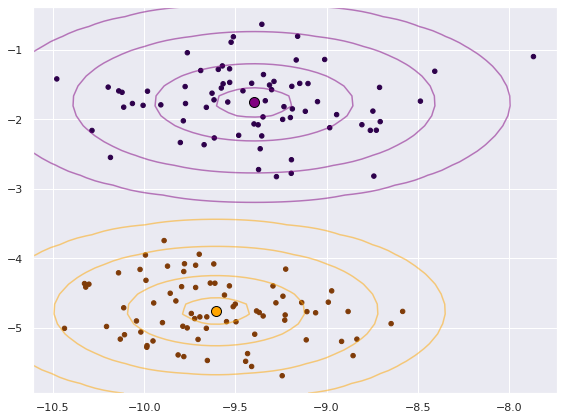

In [83]:
plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr')

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['orange', 'purple']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    #ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.2,
    #              cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.5) #   , alpha=0.2)
    # JAKE START
    
    ax.scatter(mu[0], mu[1], c=color, s=100, edgecolors='black')
    
    # JAKE END

plt.tight_layout()
fig.savefig('img/gnb-ex2.png')

In [70]:
for label, color in enumerate(['orange', 'purple']):
    print(f"COLOUR: {color}")
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    print(f"mu, std = {mu}, {std}")

COLOUR: orange
mu, std = [-9.60638165 -4.75583972], [0.41388112 0.42782964]
COLOUR: purple
mu, std = [-9.39793607 -1.75974356], [0.46255716 0.47007137]
